## 라이브러리

In [1]:
import os
import glob
import copy
import random
import shutil
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt

## 파라미터

In [2]:
params = {
    "model": "resnet18",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 8,
    "num_workers": 0,
    "epochs": 20,
    "weight_decay" : 1e-4
}

## 데이터 불러오기

In [3]:
cat_directory = "D:Dataset/dataset/etc/dogs_cats/cat/"
dog_directory = "D:Dataset/dataset/etc/dogs_cats/dog/"

cat_images_filepaths = sorted(glob.glob(cat_directory+"*"))
dog_images_filepaths = sorted(glob.glob(dog_directory+"*"))
print(len(cat_images_filepaths), len(dog_images_filepaths))
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
label = [*[1]*12500,*[0]*12500]
dataset = list(zip(images_filepaths, label))

12500 12500


In [4]:
random.shuffle(dataset)
train_ds = dataset[:20000]
val_ds = dataset[20000:-100]
test_ds = dataset[-100:]
print(len(train_ds), len(val_ds), len(test_ds))

20000 4900 100


In [5]:
train_ds[:10]

[('D:Dataset/dataset/etc/dogs_cats/cat\\cat.3738.jpg', 1),
 ('D:Dataset/dataset/etc/dogs_cats/cat\\cat.2983.jpg', 1),
 ('D:Dataset/dataset/etc/dogs_cats/cat\\cat.3395.jpg', 1),
 ('D:Dataset/dataset/etc/dogs_cats/dog\\dog.3363.jpg', 0),
 ('D:Dataset/dataset/etc/dogs_cats/cat\\cat.1013.jpg', 1),
 ('D:Dataset/dataset/etc/dogs_cats/dog\\dog.1377.jpg', 0),
 ('D:Dataset/dataset/etc/dogs_cats/dog\\dog.279.jpg', 0),
 ('D:Dataset/dataset/etc/dogs_cats/dog\\dog.469.jpg', 0),
 ('D:Dataset/dataset/etc/dogs_cats/cat\\cat.873.jpg', 1),
 ('D:Dataset/dataset/etc/dogs_cats/dog\\dog.1311.jpg', 0)]

## 데이터셋

In [3]:
one_hot = [i for i in range(2)]
one_hot

[0, 1]

In [6]:
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

class CatsVsDogsDataset(Dataset):
    def __init__(self, dataset, n_class=2,transform=None):
        self.dataset = dataset
        self.transform = transform
        self.n_class=n_class
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        (image_filepath, label) = self.dataset[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        one_hot = [for i in range(self.n_class)]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
            
        if label:
            label=np.array([0,1])
        else:
            label=np.array([1,0])
        return image, label
    
        label = self.df[self.df['name']==int(image_id)]['invasive'].values # label in Series. Change to array.
        label = label.squeeze()

In [7]:
train_transform = A.Compose(
    [
        A.RandomResizedCrop(height=128,width=128, scale=(0.5,1.0)),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(dataset=train_ds, transform=train_transform)

        
val_transform = A.Compose(
    [
        A.Resize(height=160,width=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(dataset=val_ds, transform=val_transform)
test_dataset = CatsVsDogsDataset(dataset=test_ds, transform=val_transform)

## 데이터 로더

In [8]:
train_loader = DataLoader(train_dataset,
                          batch_size=params["batch_size"],
                          shuffle=True,
                          num_workers=params["num_workers"],
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=params["batch_size"],
                        shuffle=False,
                        num_workers=params["num_workers"],
                        pin_memory=True)
test_loader = DataLoader(test_dataset,
                         batch_size=params["batch_size"],
                         shuffle=False,
                         num_workers=params["num_workers"])

In [9]:
for img, label in train_loader:
    print(img.shape)
    break

torch.Size([8, 3, 128, 128])


## 모델링

In [10]:
import torchvision.models as models
import torch.nn as nn
import torch

In [10]:
model = getattr(models, params["model"])(weights=None, num_classes=2,)
model = model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"],weight_decay=params["weight_decay"])

In [11]:
class MetricMonitor:

    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join([
            "{metric_name}: {avg:.{float_precision}f}".format(
                metric_name=metric_name,
                avg=metric["avg"],
                float_precision=self.float_precision)
            for (metric_name, metric) in self.metrics.items()
        ])

## 훈련

In [12]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float()
        output = model(images)
        loss = criterion(output, target)
        acc = (output.argmax(dim=-1) == target.argmax(dim=-1)).float().mean()
        
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", acc.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [12]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float()
            output = model(images)
            loss = criterion(output, target)
            acc = (output.argmax(dim=-1) == target.argmax(dim=-1)).float().mean()

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", acc.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [14]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.670 | Accuracy: 0.604: 100%|█████████████████████████| 2500/2500 [01:26<00:00, 28.77it/s]
Epoch: 1. Validation. Loss: 0.636 | Accuracy: 0.649: 100%|███████████████████████████| 613/613 [00:19<00:00, 32.14it/s]
Epoch: 2. Train.      Loss: 0.607 | Accuracy: 0.674: 100%|█████████████████████████| 2500/2500 [01:24<00:00, 29.70it/s]
Epoch: 2. Validation. Loss: 0.568 | Accuracy: 0.707: 100%|███████████████████████████| 613/613 [00:18<00:00, 32.52it/s]
Epoch: 3. Train.      Loss: 0.535 | Accuracy: 0.730: 100%|█████████████████████████| 2500/2500 [01:26<00:00, 28.94it/s]
Epoch: 3. Validation. Loss: 0.490 | Accuracy: 0.760: 100%|███████████████████████████| 613/613 [00:18<00:00, 32.30it/s]
Epoch: 4. Train.      Loss: 0.454 | Accuracy: 0.789: 100%|█████████████████████████| 2500/2500 [01:28<00:00, 28.12it/s]
Epoch: 4. Validation. Loss: 0.381 | Accuracy: 0.827: 100%|███████████████████████████| 613/613 [00:19<00:00, 30.94it/s]
Epoch: 5. Train.      Loss: 0.381 | Accu

In [15]:
epoch=1
validate(test_loader, model, criterion, epoch, params)

Epoch: 1. Validation. Loss: 0.062 | Accuracy: 0.971: 100%|█████████████████████████████| 13/13 [00:00<00:00, 21.32it/s]


## CutMix

### rand_bbox

* rand_bbox 함수는 패치를 생성하는 코드입니다.
* 주어진 이미지 크기 내에서, 랜덤하게 패치를 만들어내고 이에 대한 좌표를 반환하는 함수입니다.
* 패치의 폭과 넓이는, 주어진 이미지의 폭과 넓이에 np.sqrt(1-lam)을 곱하여 얻게 됩니다.
* 여기서 lam은 베타분포에서 랜덤하게 얻은 값입니다. 이렇게 얻어낸 패치 부분을, 랜덤하게 섞은 X(input)값들의 패치 부분으로 교체합니다.
* 이때 합성된 이미지의 레이블은, 합성된 전체 이미지에서 각각의 이미지가 차지하는 면적 비율만큼(lam)을 더한 값이 됩니다.

In [13]:
def rand_bbox(size, lam): # size : [B, C, W, H], lam : Beta 분포의 random 값
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = np.int32(W * cut_rat,)  # 패치의 너비
    cut_h = np.int32(H * cut_rat)  # 패치의 높이

    # uniform
    # 기존 이미지의 크기에서 랜덤하게 값을 가져옵니다.(중간 좌표 추출)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

### 배치 내의 데이터 셔플

In [17]:
X,y = next(iter(train_loader))
X = X.to(params["device"])
y = y.to(params["device"])

lam = np.random.beta(1.0, 1.0)  # 베타 분포에서 lam 값을 가져옵나다.
rand_index = torch.randperm(X.size()[0]).to(params["device"]) # batch_size 내의 랜덤 index
shuffled_y = y[rand_index] # 타겟 레이블을 랜덤하게 셔플합니다.
print(lam)
print(rand_index)

0.9459254064102329
tensor([1, 3, 2, 7, 6, 4, 0, 5], device='cuda:0')


### 패치 부분 교체

In [18]:
bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam) # bbox 정보 받기
X[:,:,bbx1:bbx2, bby1:bby2] = X[rand_index,:,bbx1:bbx2, bby1:bby2] # 배치 순서, bbox 위치 교환

lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (X.size()[-1] * X.size()[-2])) # lambda 재조정
print(lam) 

0.9521484375


### 결과

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


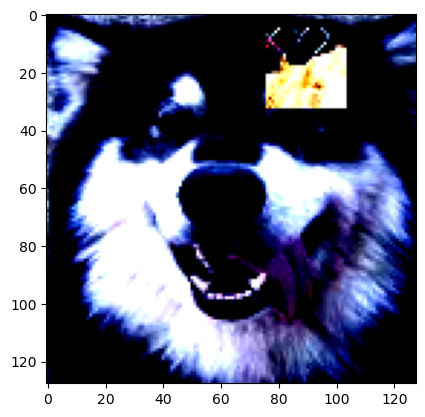

In [19]:
plt.imshow(X[0].permute(1, 2, 0).cpu());plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


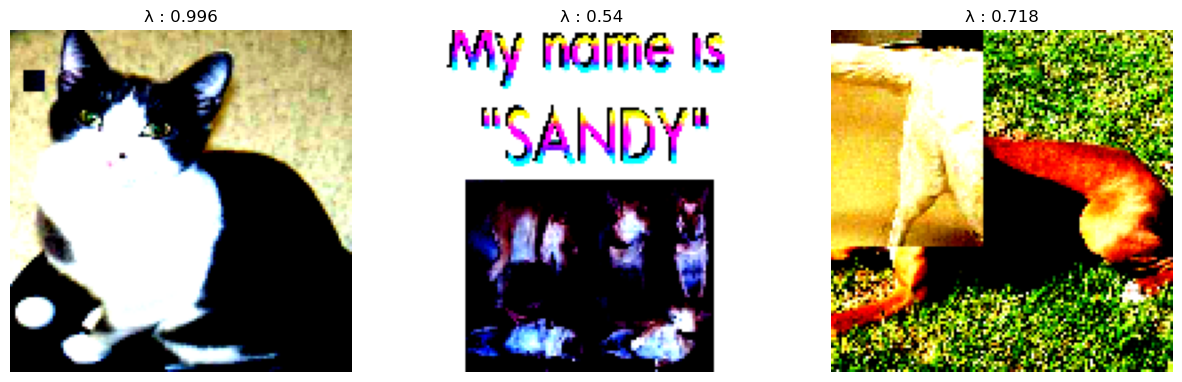

In [14]:
def cutmix_plot(train_loader):
    fig , axes = plt.subplots(1,3)
    fig.set_size_inches(15,12)
    
    for i in range(3):
        for inputs, targets in train_loader:
            inputs = inputs
            targets = targets
            break

        lam = np.random.beta(1.0, 1.0) 
        rand_index = torch.randperm(inputs.size()[0])
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
        axes[i].imshow(inputs[1].permute(1, 2, 0).cpu())
        axes[i].set_title(f'λ : {np.round(lam,3)}')
        axes[i].axis('off')
    return

cutmix_plot(train_loader)

## CutMix 적용 훈련

In [15]:
def cutmix_train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float()
        
        if np.random.random()>0.5: # cutmix 작동될 확률      
            lam = np.random.beta(1.0, 1.0)
            rand_index = torch.randperm(images.size()[0]).to(params["device"])
            target_a = target
            target_b = target[rand_index]            
            bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
            output = model(images)
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)

        else:
            output = model(images)
            loss = criterion(output, target)
            
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [16]:
model = getattr(models, params["model"])(weights=None, num_classes=2,)
model = model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"],weight_decay=params["weight_decay"])

In [17]:
for epoch in range(1, params["epochs"] + 1):
    cutmix_train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.679: 100%|███████████████████████████████████████████| 2500/2500 [02:14<00:00, 18.64it/s]
Epoch: 1. Validation. Loss: 0.605 | Accuracy: 0.675: 100%|███████████████████████████| 613/613 [00:35<00:00, 17.06it/s]
Epoch: 2. Train.      Loss: 0.625: 100%|███████████████████████████████████████████| 2500/2500 [01:24<00:00, 29.74it/s]
Epoch: 2. Validation. Loss: 0.568 | Accuracy: 0.704: 100%|███████████████████████████| 613/613 [00:18<00:00, 33.34it/s]
Epoch: 3. Train.      Loss: 0.583: 100%|███████████████████████████████████████████| 2500/2500 [01:27<00:00, 28.45it/s]
Epoch: 3. Validation. Loss: 0.485 | Accuracy: 0.765: 100%|███████████████████████████| 613/613 [00:18<00:00, 33.44it/s]
Epoch: 4. Train.      Loss: 0.537: 100%|███████████████████████████████████████████| 2500/2500 [01:25<00:00, 29.21it/s]
Epoch: 4. Validation. Loss: 0.400 | Accuracy: 0.824: 100%|███████████████████████████| 613/613 [00:18<00:00, 33.62it/s]
Epoch: 5. Train.      Loss: 0.498: 100%|

In [18]:
epoch=1
validate(test_loader, model, criterion, epoch, params)

Epoch: 1. Validation. Loss: 0.102 | Accuracy: 0.981: 100%|█████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


In [19]:
for epoch in range(params["epochs"] + 1,params["epochs"] + 5):
    cutmix_train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 21. Train.      Loss: 0.290: 100%|██████████████████████████████████████████| 2500/2500 [01:24<00:00, 29.45it/s]
Epoch: 21. Validation. Loss: 0.170 | Accuracy: 0.936: 100%|██████████████████████████| 613/613 [00:18<00:00, 32.91it/s]
Epoch: 22. Train.      Loss: 0.287: 100%|██████████████████████████████████████████| 2500/2500 [01:25<00:00, 29.40it/s]
Epoch: 22. Validation. Loss: 0.144 | Accuracy: 0.948: 100%|██████████████████████████| 613/613 [00:18<00:00, 32.90it/s]
Epoch: 23. Train.      Loss: 0.284: 100%|██████████████████████████████████████████| 2500/2500 [01:25<00:00, 29.23it/s]
Epoch: 23. Validation. Loss: 0.156 | Accuracy: 0.950: 100%|██████████████████████████| 613/613 [00:18<00:00, 33.39it/s]
Epoch: 24. Train.      Loss: 0.282: 100%|██████████████████████████████████████████| 2500/2500 [01:25<00:00, 29.37it/s]
Epoch: 24. Validation. Loss: 0.160 | Accuracy: 0.944: 100%|██████████████████████████| 613/613 [00:18<00:00, 32.84it/s]


In [22]:
epoch=1
validate(test_loader, model, criterion, epoch, params)

Epoch: 1. Validation. Loss: 0.091 | Accuracy: 0.971: 100%|█████████████████████████████| 13/13 [00:00<00:00, 21.59it/s]


# 결과

이번 실험으로는 CutMix로 했을때와 하지 않았을 때를 비교하기는 크게 좋지 않은 것 같다.

두개의 클래스 보다, 다중 클래스에서 작용하는 것에 더 효과적일 것이라는 생각이 들었다.

또한 지금 Cat Dog 이미지에서는 100x100 크기 부터 1000x500 까지 가지는데 크기의 차이가 크게 나타나는데

이런 경우에서 lam 값을 어떻게 가지느냐에 따라 성능이 크게 달라질것같다.

lam을 얻을 때, Beta 분포에서 최대값을 조금더 적게 가지고 실험을 다시 해보는 것도 좋을것 같다.